/usr/local/lib/python3.10/dist-packages/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")


final text_encoder_type: bert-base-uncased
Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


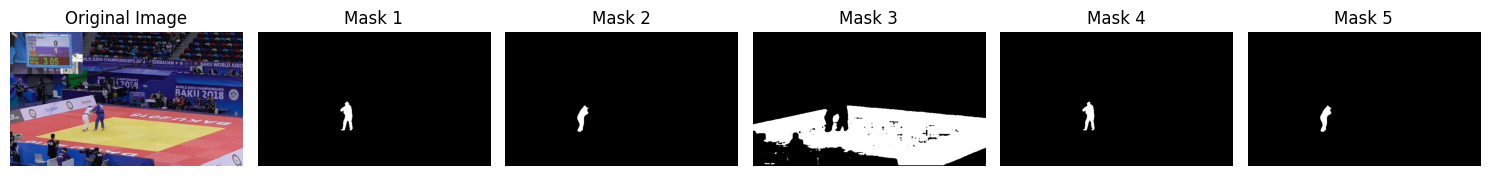

Rectangle(xy=(196.32, 204.596), width=38.4155, height=68.3114, angle=0)


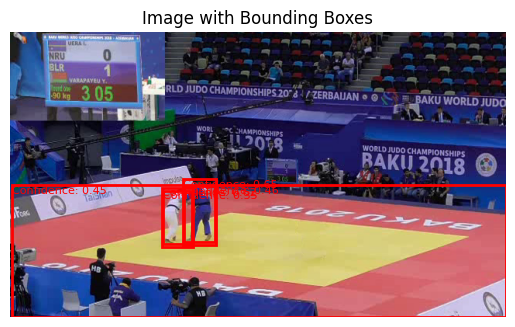

Bounding Boxes:
Box 1: tensor([223.2883, 190.0236, 264.7200, 274.8701])
Box 2: tensor([196.0692, 200.5406, 236.1370, 277.4006])
Box 3: tensor([  1.5390, 197.3192, 639.2767, 367.4439])
Box 4: tensor([224.5982, 198.3095, 264.2557, 270.5952])
Box 5: tensor([196.3204, 204.5959, 234.7359, 272.9074])

Detected Phrases:
Phrase 1: two person
Phrase 2: two person
Phrase 3: the yellow floor the yellow floor
Phrase 4: white blue
Phrase 5: white blue

Confidence:
Logit 1: 0.6511991620063782
Logit 2: 0.6242445707321167
Logit 3: 0.4540020227432251
Logit 4: 0.46233880519866943
Logit 5: 0.3477430045604706


In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
from lang_sam import LangSAM
from lang_sam.utils import draw_image
import cv2

# image = "https://static01.nyt.com/images/2020/09/08/well/physed-cycle-walk/physed-cycle-walk-videoSixteenByNineJumbo1600-v2.jpg"
image = "/content/審判削除1フレーム.png"
text_prompt = "two person in white and in blue on the yellow floor, the yellow floor."

def download_image(url):
    response = requests.get(url)
    response.raise_for_status()
    return Image.open(BytesIO(response.content)).convert("RGB")

def save_mask(mask_np, filename):
    mask_image = Image.fromarray((mask_np * 255).astype(np.uint8))
    mask_image.save(filename)

def display_image_with_masks(image, masks):
    num_masks = len(masks)

    fig, axes = plt.subplots(1, num_masks + 1, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    for i, mask_np in enumerate(masks):
        axes[i+1].imshow(mask_np, cmap='gray')
        axes[i+1].set_title(f"Mask {i+1}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

def display_image_with_boxes(image, boxes, logits):
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title("Image with Bounding Boxes")
    ax.axis('off')

    for box, logit in zip(boxes, logits):
        x_min, y_min, x_max, y_max = box
        confidence_score = round(logit.item(), 2)  # Convert logit to a scalar before rounding
        box_width = x_max - x_min
        box_height = y_max - y_min

        # Draw bounding box
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

        # Add confidence score as text
        ax.text(x_min, y_min, f"Confidence: {confidence_score}", fontsize=8, color='red', verticalalignment='top')
    print(rect)
    plt.show()

def print_bounding_boxes(boxes):
    print("Bounding Boxes:")
    for i, box in enumerate(boxes):
        print(f"Box {i+1}: {box}")

def print_detected_phrases(phrases):
    print("\nDetected Phrases:")
    for i, phrase in enumerate(phrases):
        print(f"Phrase {i+1}: {phrase}")

def print_logits(logits):
    print("\nConfidence:")
    for i, logit in enumerate(logits):
        print(f"Logit {i+1}: {logit}")

def main():
    # Suppress warning messages
    warnings.filterwarnings("ignore")

    try:
        if image.startswith("http"):
            image_pil = download_image(image)
        else:
            image_pil = Image.open(image).convert("RGB")

        model = LangSAM()
        masks, boxes, phrases, logits = model.predict(image_pil, text_prompt)

        if len(masks) == 0:
            print(f"No objects of the '{text_prompt}' prompt detected in the image.")
        else:
            # Convert masks to numpy arrays
            masks_np = [mask.squeeze().cpu().numpy() for mask in masks]

            # Display the original image and masks side by side
            display_image_with_masks(image_pil, masks_np)

            # Display the image with bounding boxes and confidence scores
            display_image_with_boxes(image_pil, boxes, logits)

            # Save the masks
            for i, mask_np in enumerate(masks_np):
                mask_path = f"image_mask_{i+1}.png"
                save_mask(mask_np, mask_path)

            # Print the bounding boxes, phrases, and logits
            print_bounding_boxes(boxes)
            print_detected_phrases(phrases)
            print_logits(logits)

    except (requests.exceptions.RequestException, IOError) as e:
        print(f"Error: {e}")
    return image_pil, masks_np, boxes, phrases, logits
if __name__ == "__main__":
    image_pil, masks_np, boxes, phrases, logits = main()

In [23]:
sum(masks_np[:2]).shape

(368, 640)

In [25]:
masks_np = cv2.cvtColor(sum(masks_np[:2]).astype(np.uint8) * 255, cv2.COLOR_GRAY2BGR)

In [27]:
masks_np.shape

(368, 640, 3)

In [28]:
frame = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)

result_img = cv2.bitwise_and(frame, masks_np)  #切り向き画像

In [30]:
cv2.imwrite("inpaint_out.png", masks_np)

True

In [16]:
masks_np[0]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [1]:
!ffmpeg -i "/content/drive/MyDrive/Colab Notebooks/2023年度スポコン/__temp__.mp4" -vcodec png /content/image_%04d.png

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

1


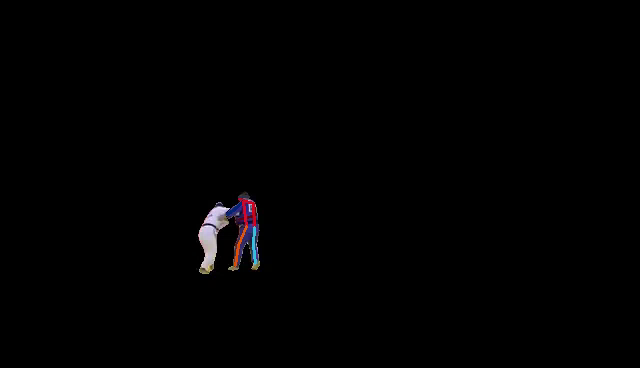

2


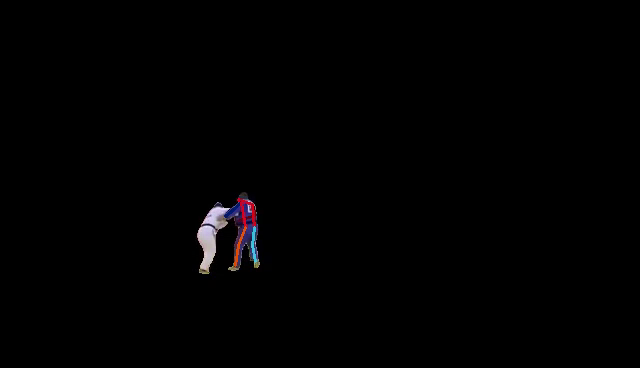

3


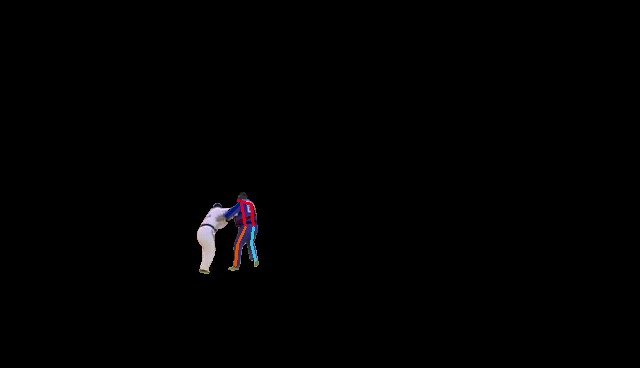

4


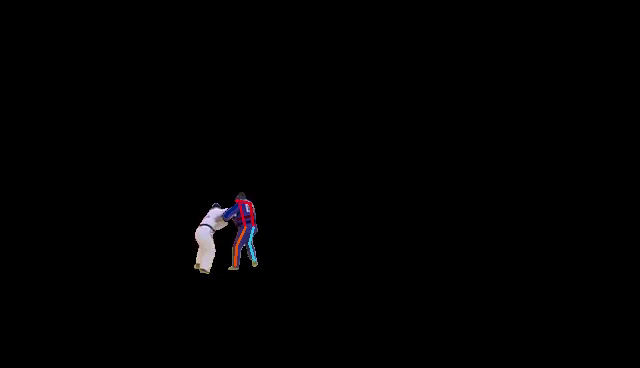

5


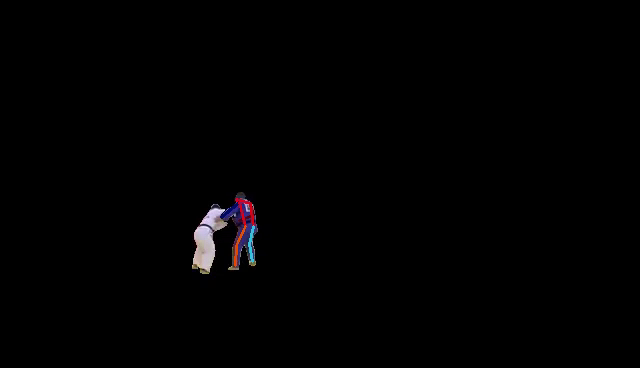

6


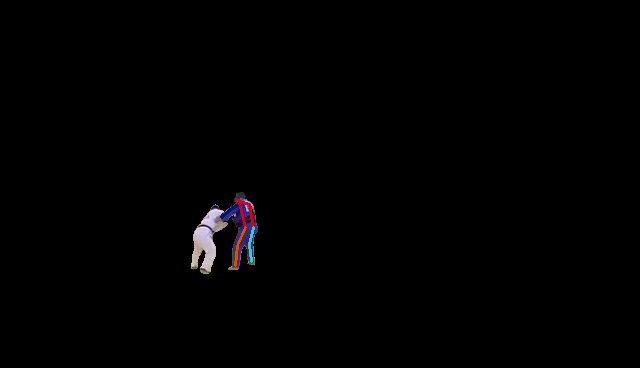

7


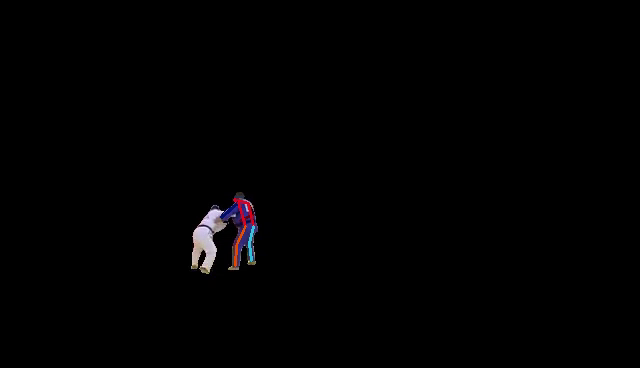

8


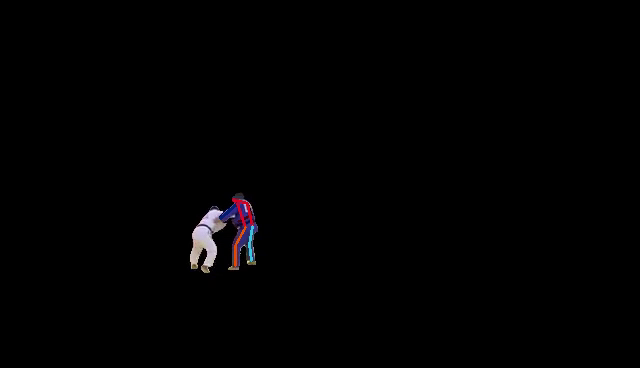

9


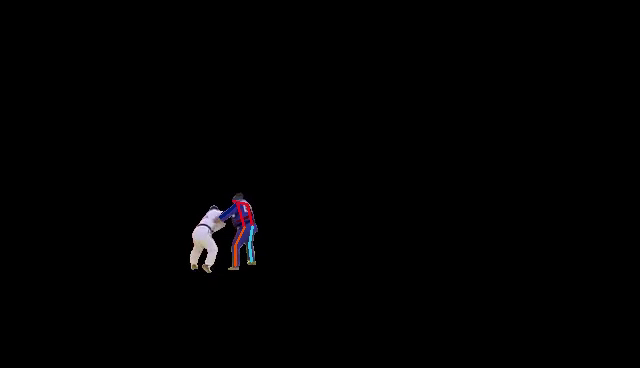

10


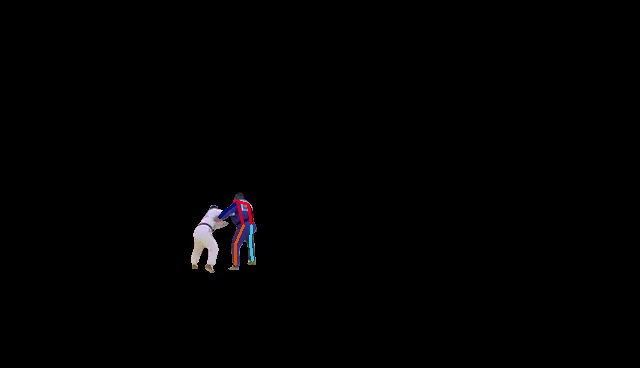

11


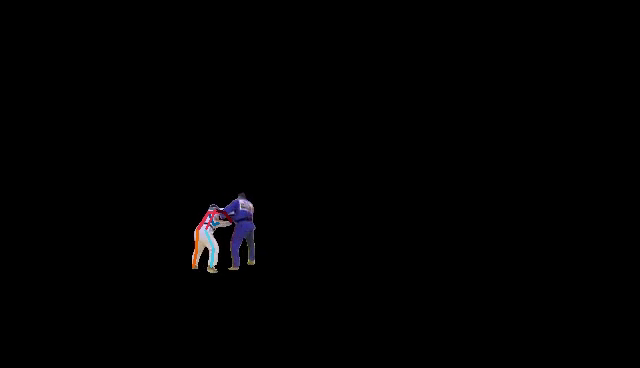

12


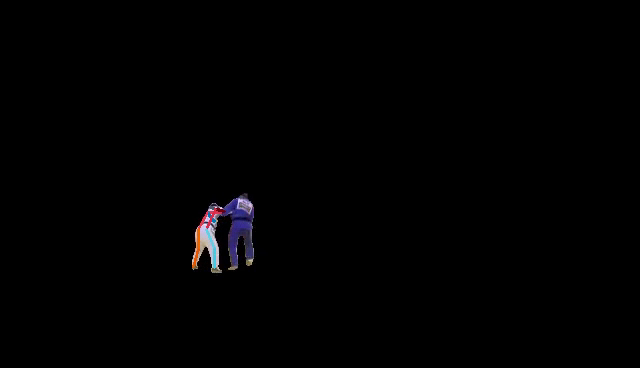

13


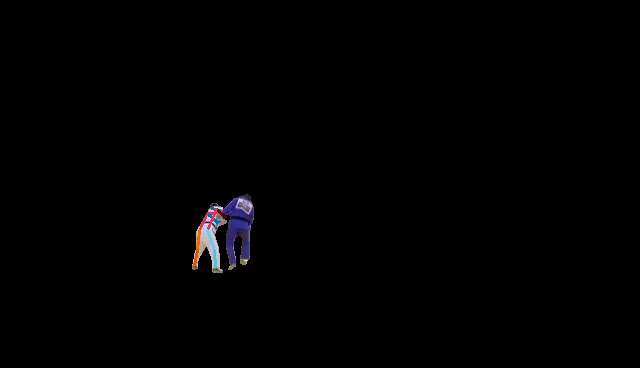

14


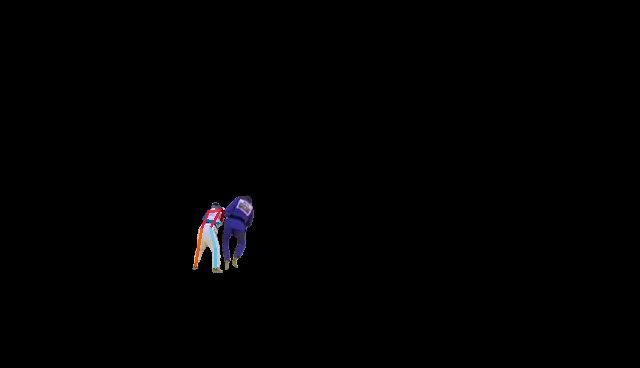

15


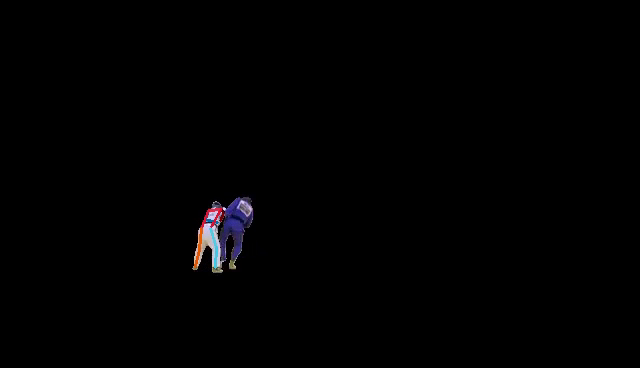

16


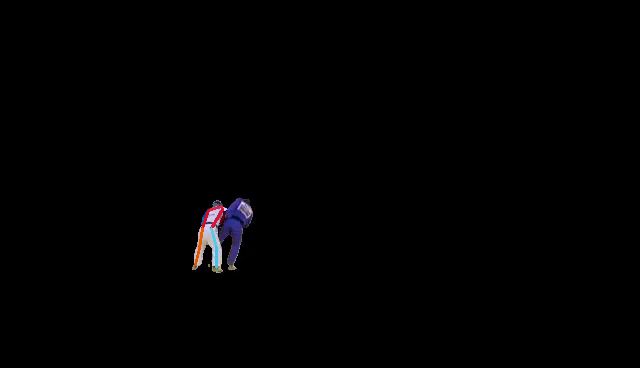

17


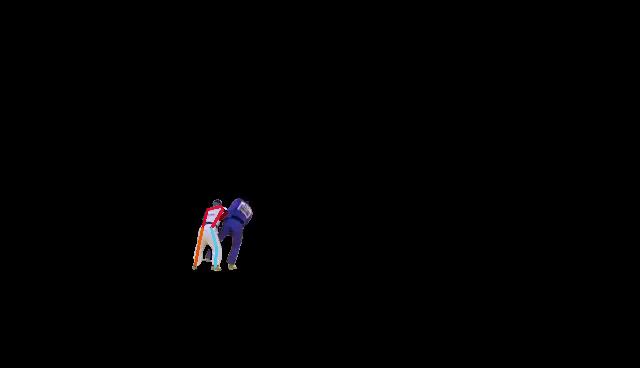

18


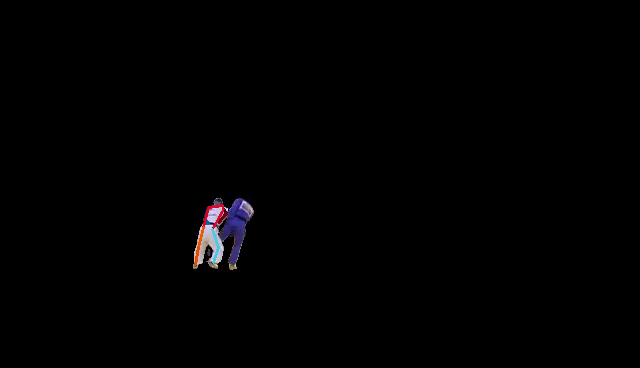

19


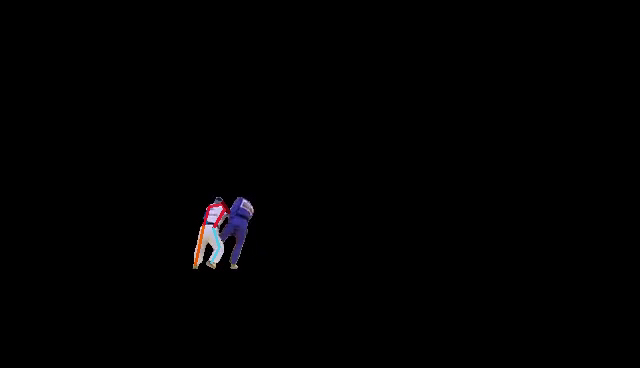

20


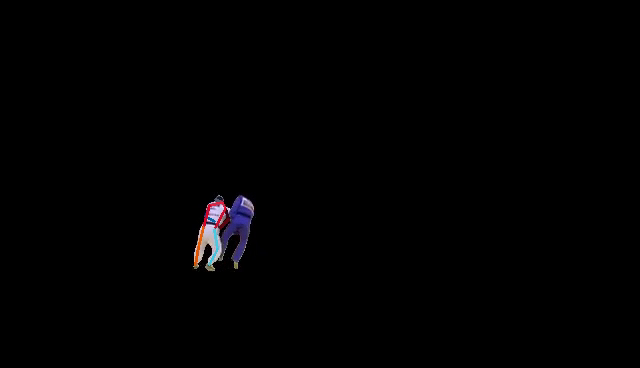

21


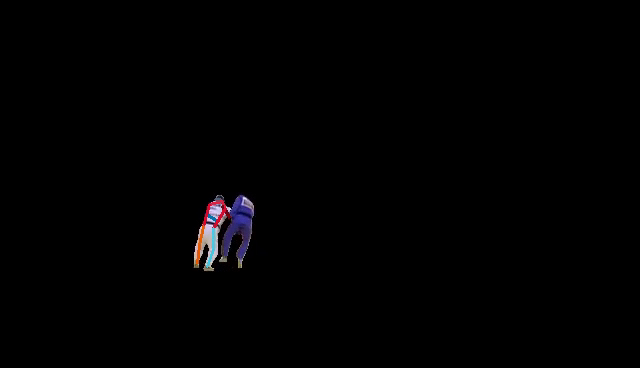

22


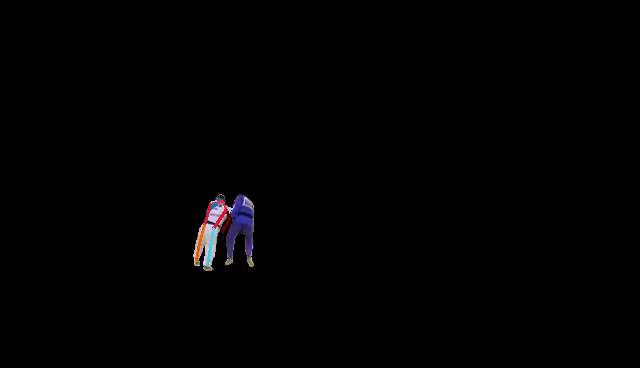

23


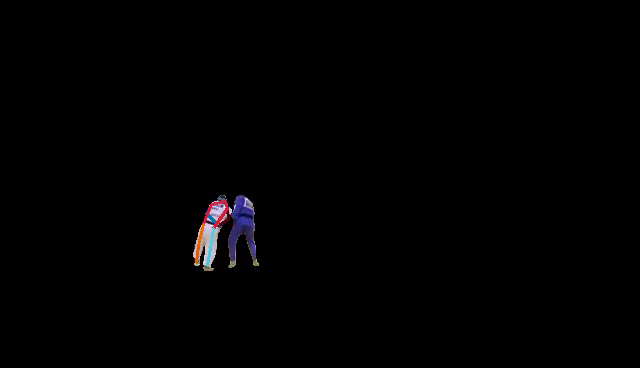

24


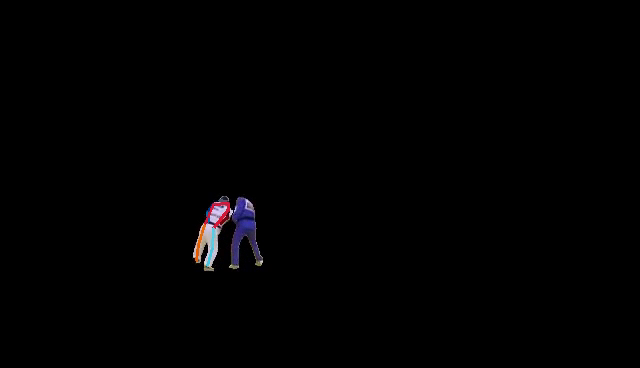

25


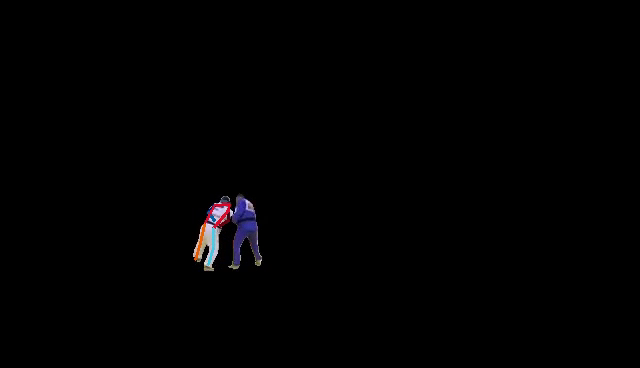

26


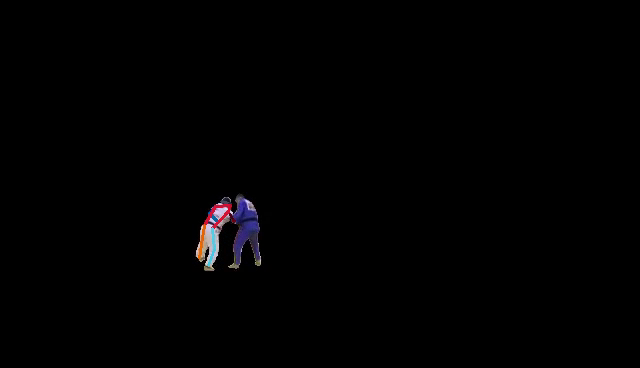

27


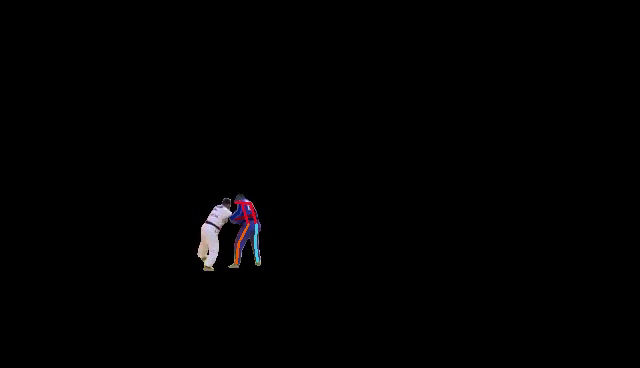

28


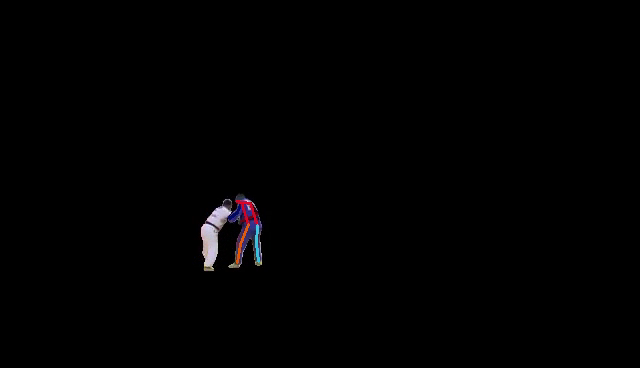

29


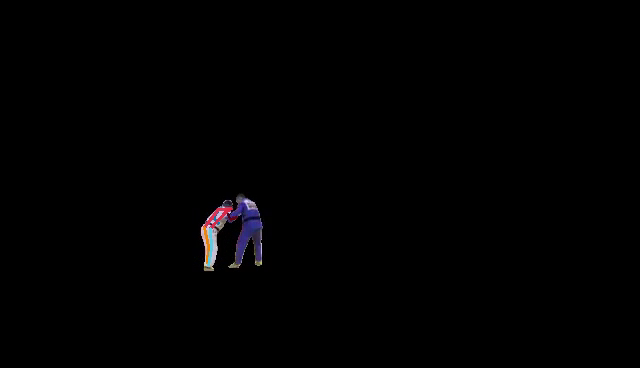

30


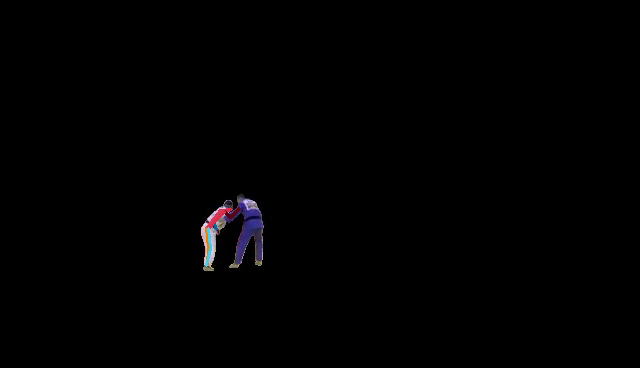

31


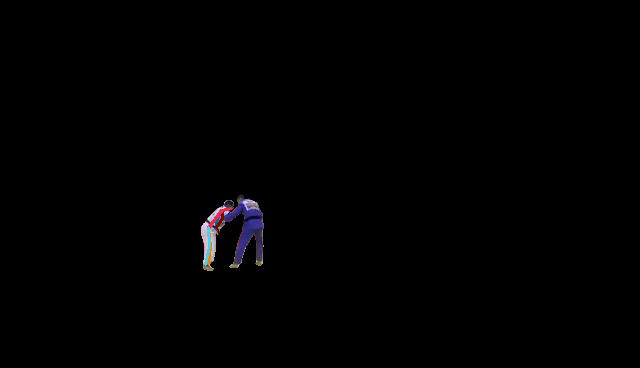

32


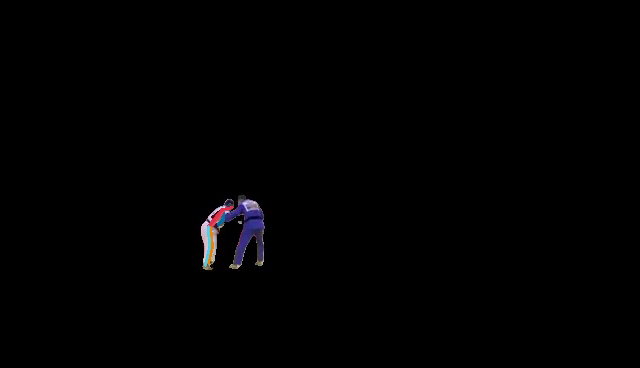

33


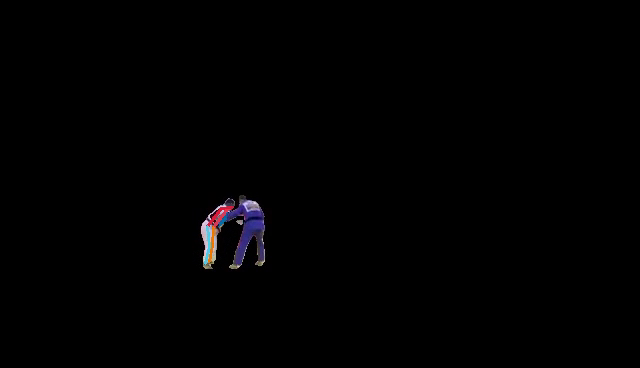

34


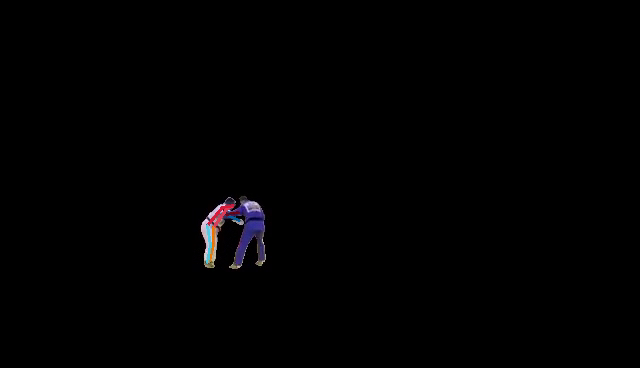

35


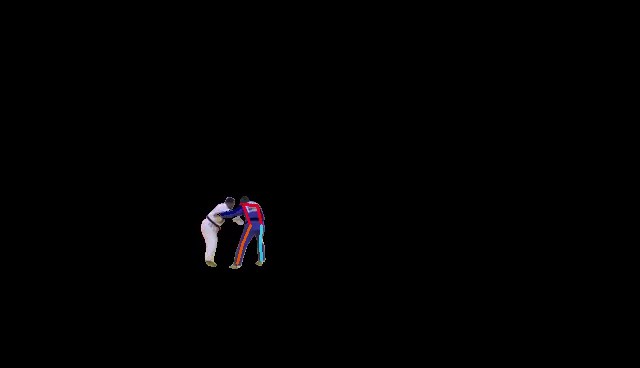

36


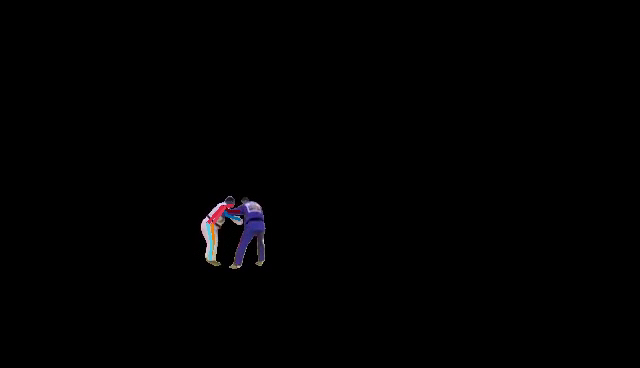

37


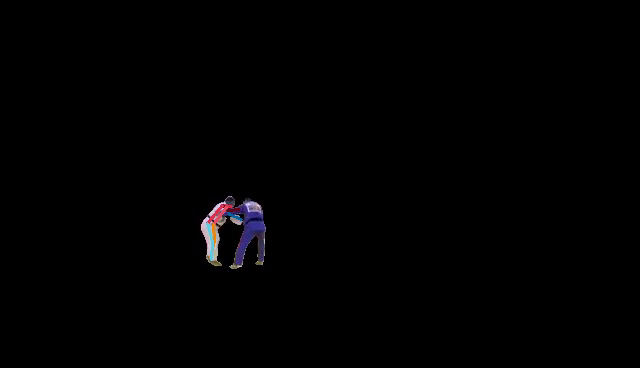

38


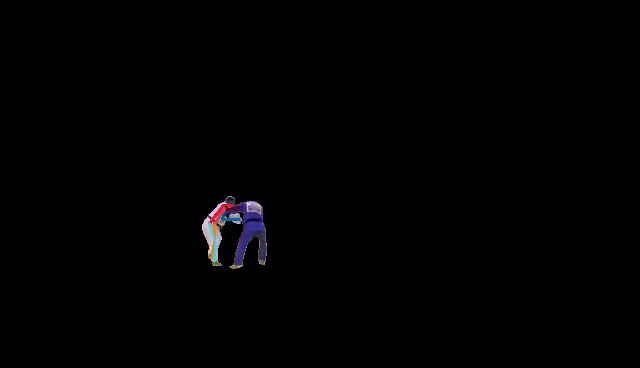

39


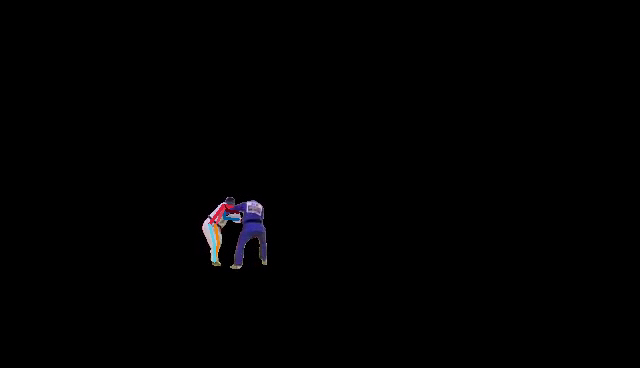

40


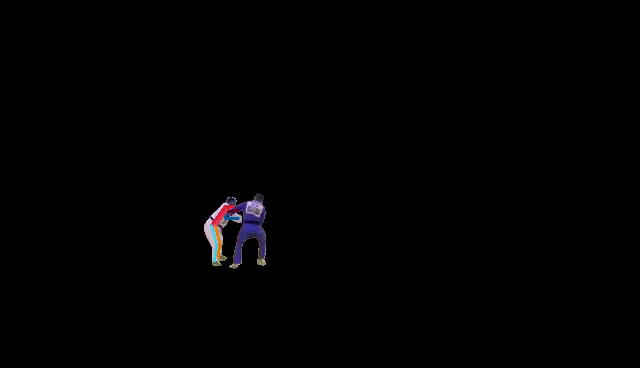

41


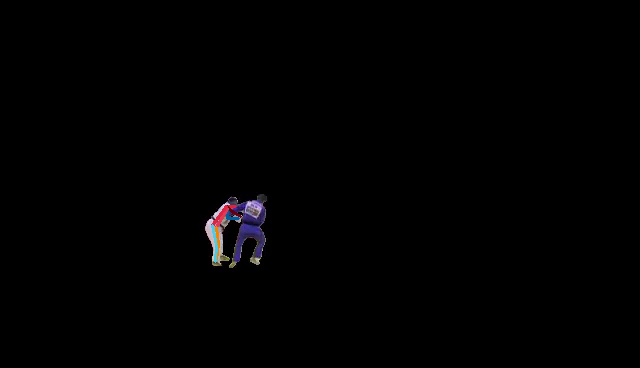

42


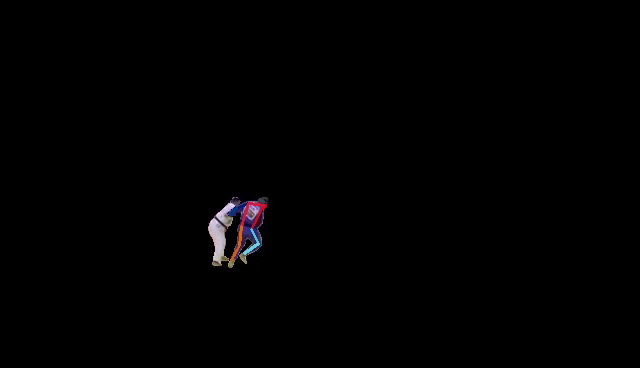

43


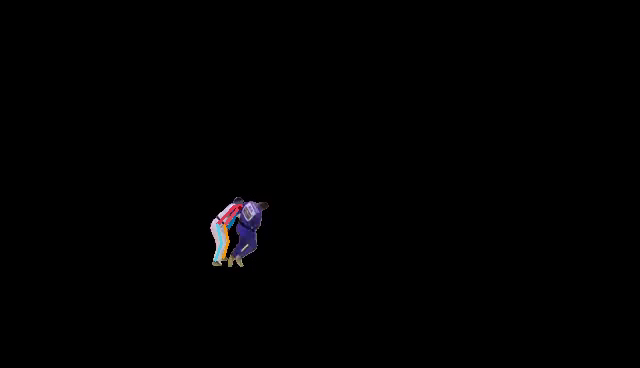

44


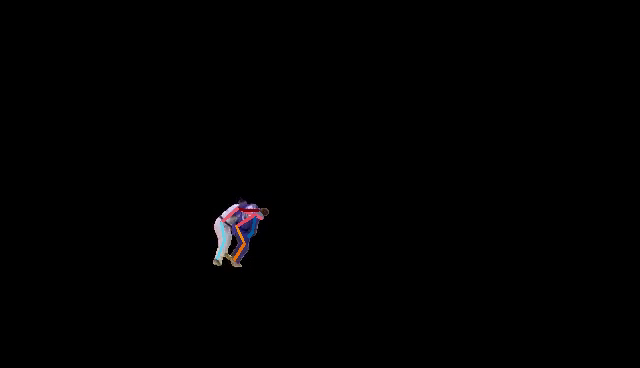

45


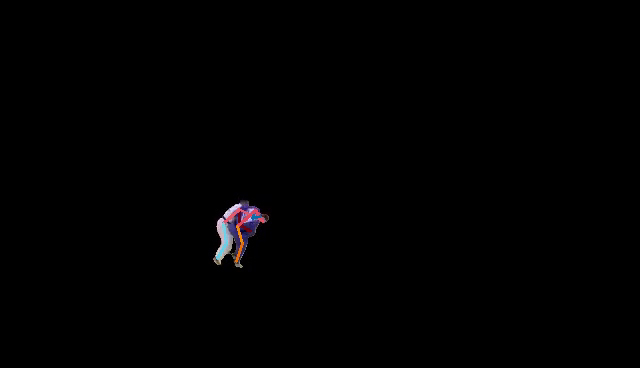

46


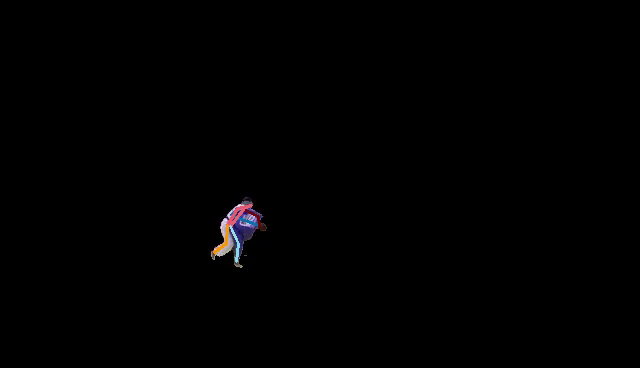

47


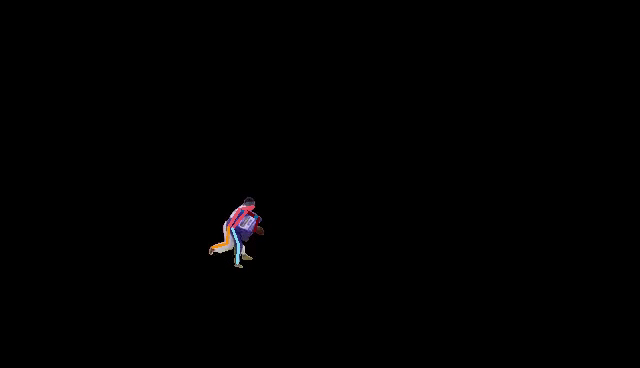

48


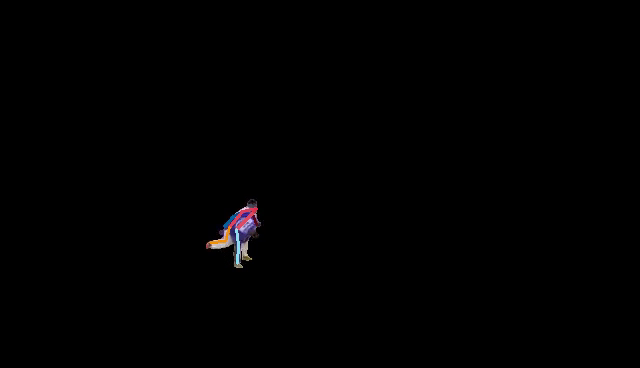

49


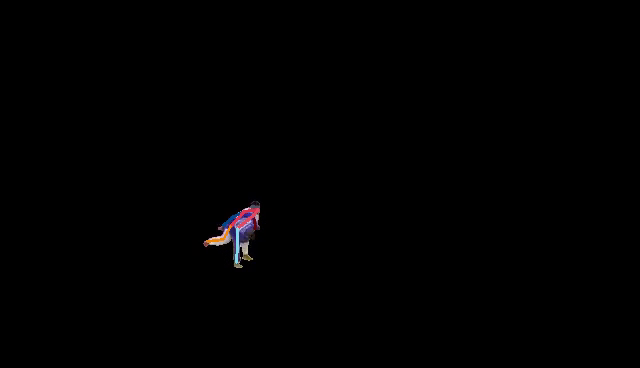

50


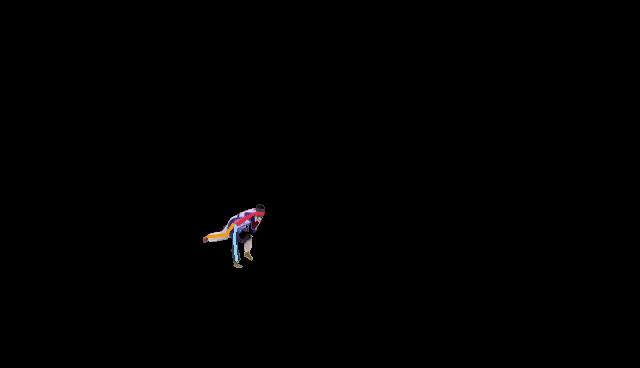

51


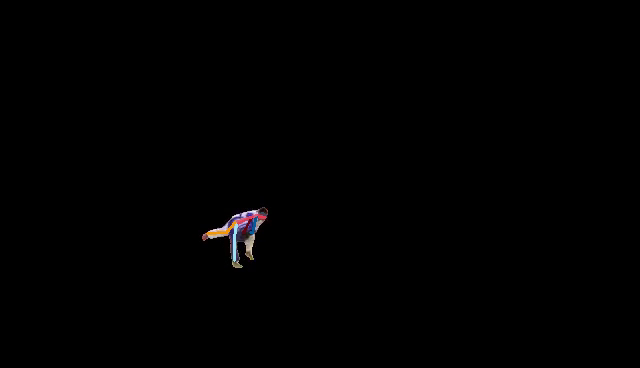

52


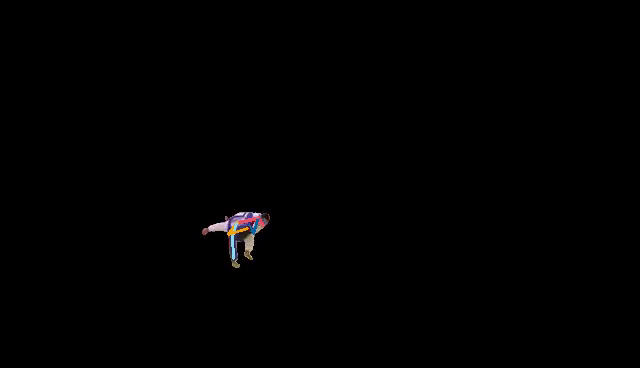

53


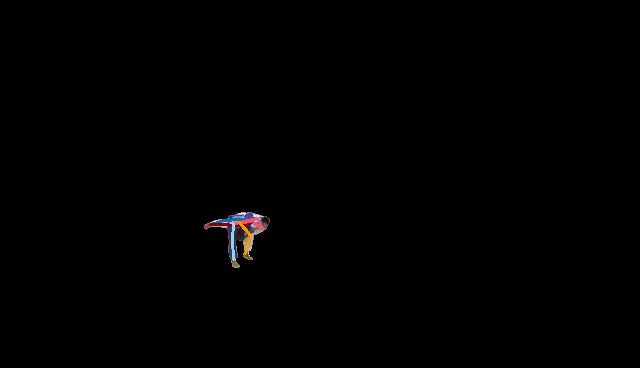

54


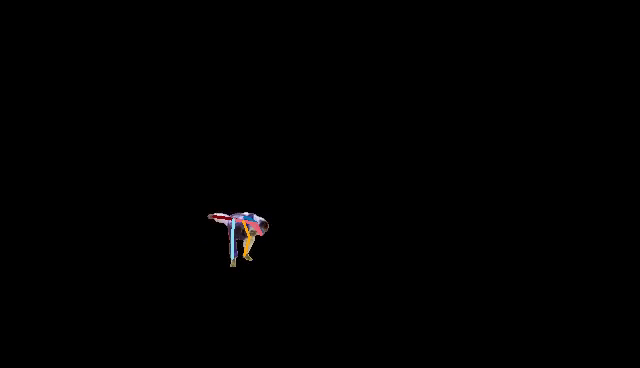

55


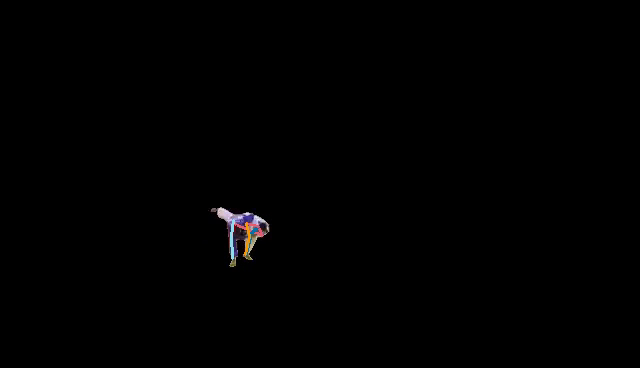

56


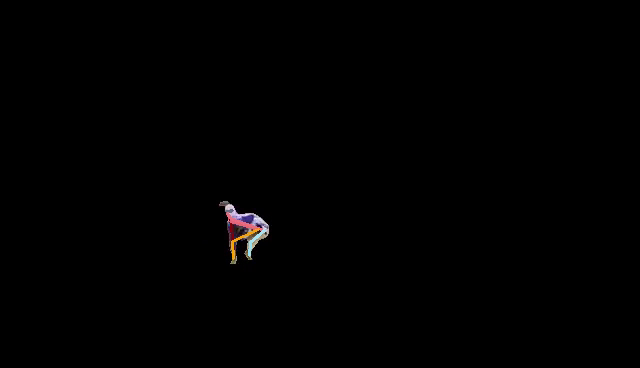

57


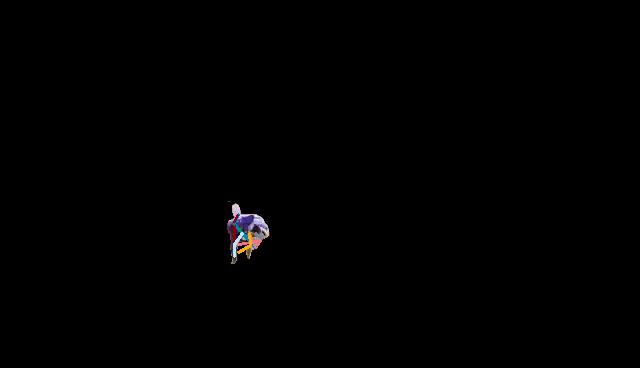

58


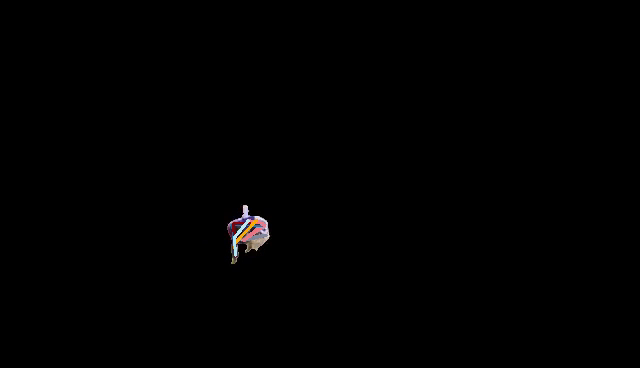

59


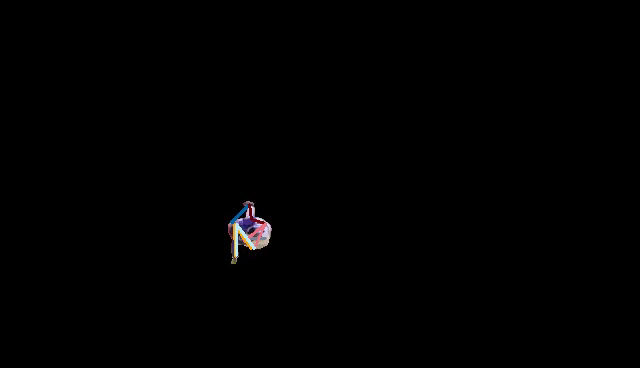

60


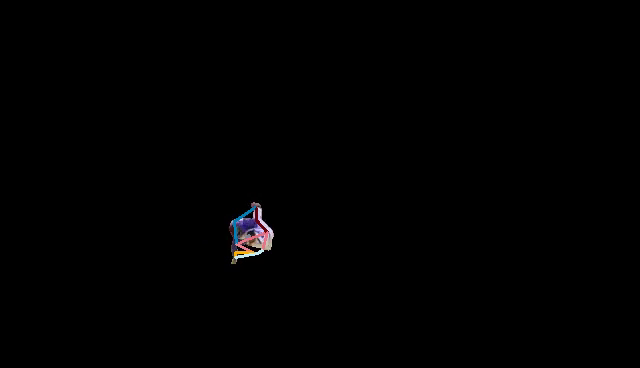

61


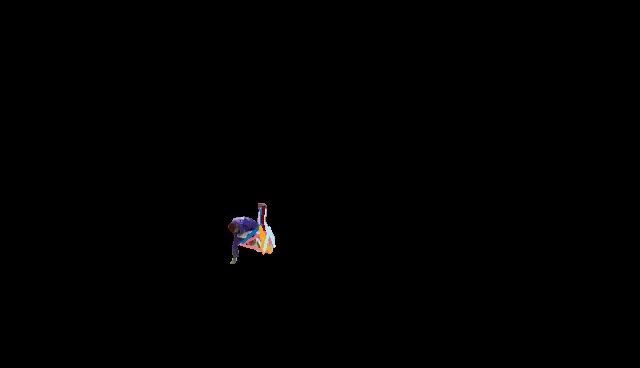

62


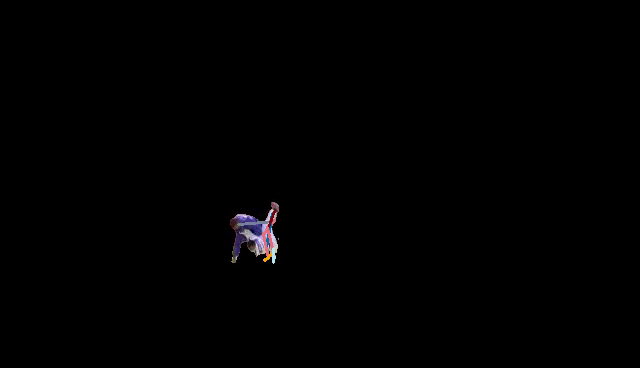

63


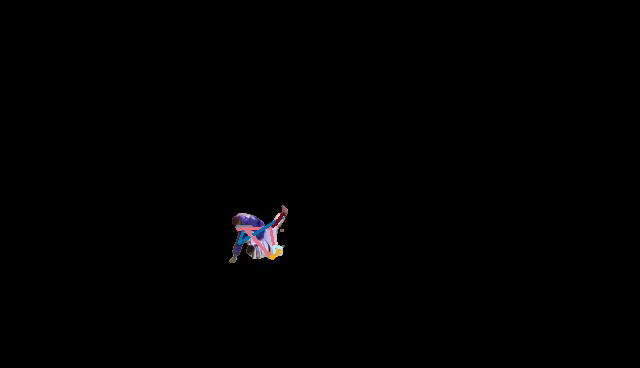

64


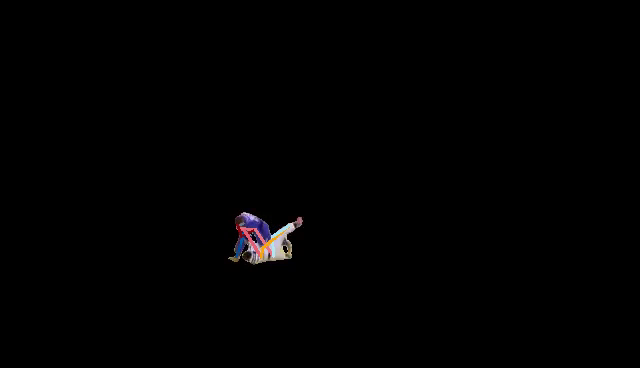

65


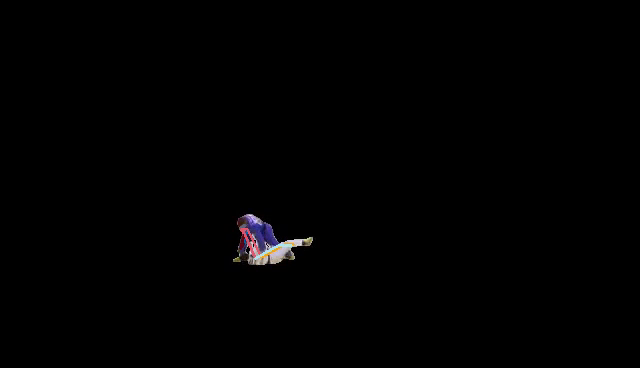

66


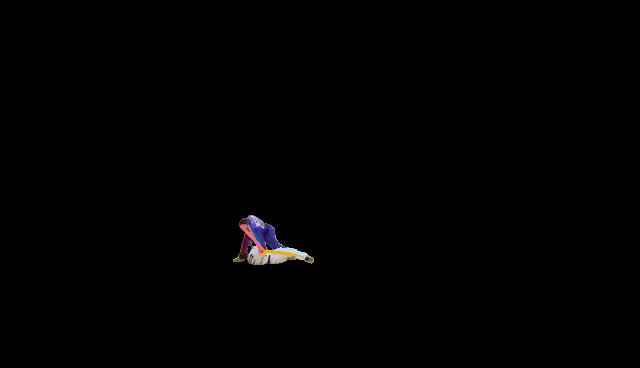

67


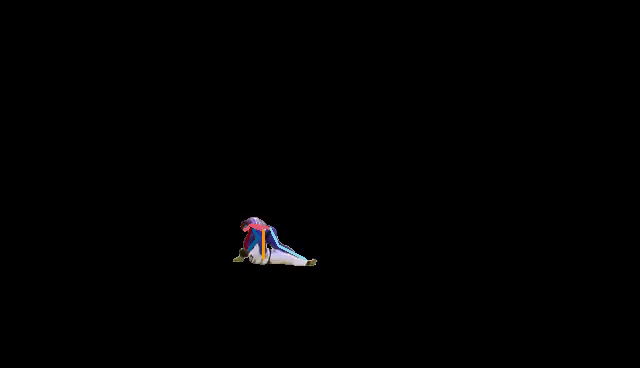

68


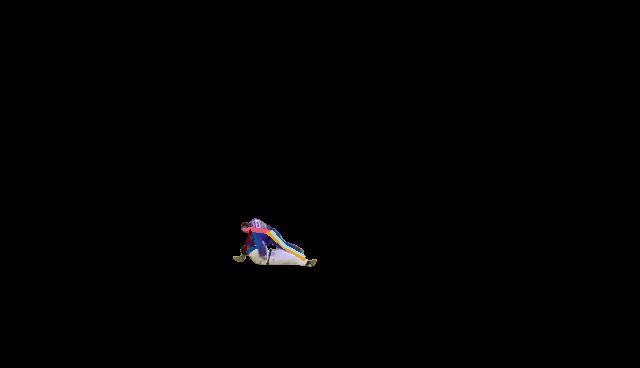

69


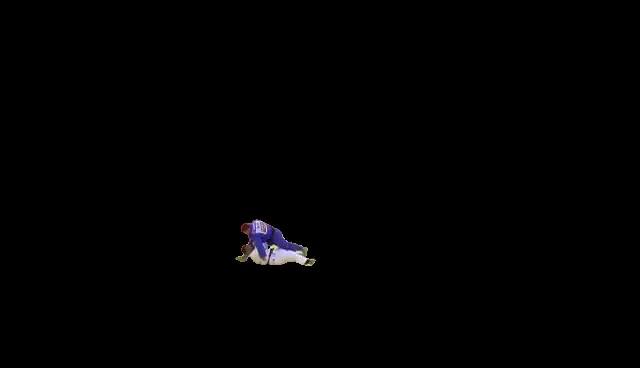

70


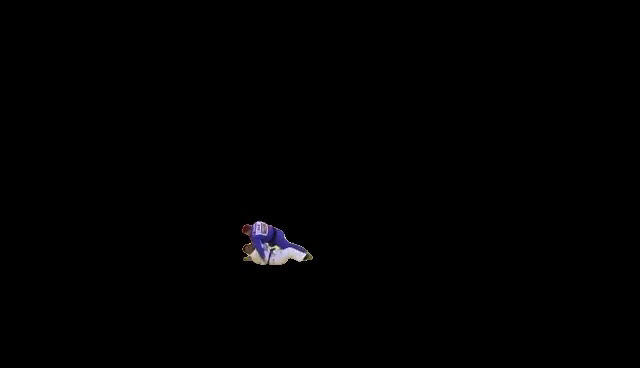

71


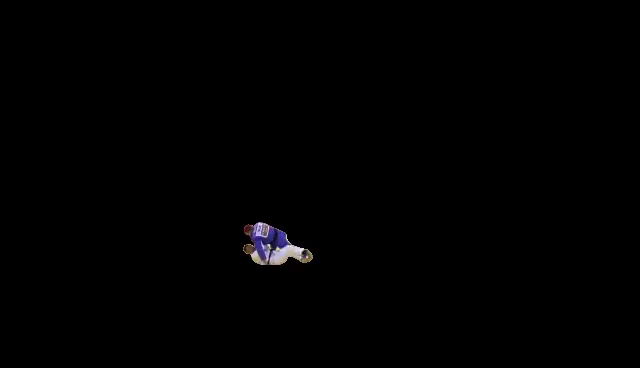

72


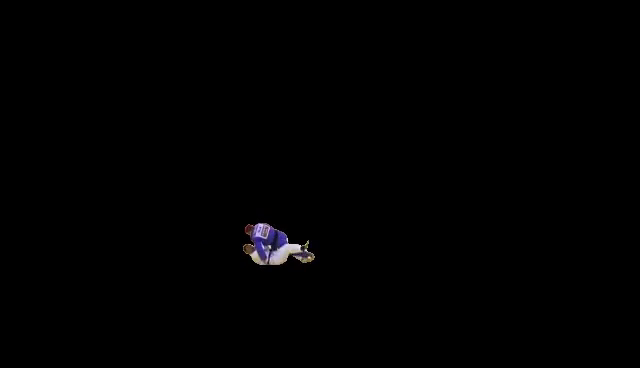

73


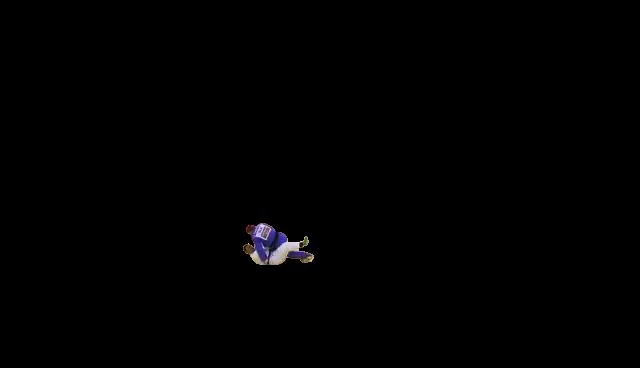

In [14]:
from itertools import count
from google.colab.patches import cv2_imshow
import os
import cv2
imgs_ls = sorted([img_ls for img_ls in os.listdir("/content") if img_ls[-3:] == 'png'])
count = 1
for i in imgs_ls:
  img = cv2.imread(f"/content/{i}")
  print(count)
  cv2_imshow(img)
  count += 1